In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats.stats import pearsonr
from IPython.display import display, Markdown, Latex
plt.style.use('ggplot')
from datetime import date
data_path = '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/'
#import dask.dataframe as dd
from scipy.stats import norm
from sklearn.cluster import KMeans
import numpy as np

import pandas



/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_57246/1634516992.py:8: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [3]:
#load mobility and temperature data
#load heatwave - control dataframe
mobility_heat = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/Brazil/THI_mobility_heat_clean_90.csv')
heatwave_control = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/Brazil/THI_heatwave_control_90.csv')

In [4]:
len(heatwave_control['location'].unique())

3618

## Build Intensity Variable


In [5]:
full_df = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/THI/brazil/daily_max_THI.csv')

full_df.rename(columns={'time': 'datetime'}, inplace=True)
full_df['datetime'] = pd.to_datetime(full_df['datetime'])
full_df['day'] = pd.DatetimeIndex(full_df['datetime']).day
full_df['month'] = pd.DatetimeIndex(full_df['datetime']).month
full_df['year'] = pd.DatetimeIndex(full_df['datetime']).year
full_df.month.unique()
full_df = full_df[~full_df['month'].isin([9, 10, 4])]

full_df['location'] = full_df['adm2'] + ', ' + full_df['adm1']
full_df['datetime_ord'] = [date(x,y,z).toordinal() for x,y,z in zip(full_df['year'], full_df['month'], full_df['day'])]


In [6]:
mobility_heat['control_day'] = pd.to_datetime(mobility_heat['control_day'])

In [7]:
#merge temperatures from control day onto mobility heat
mobility_heat = mobility_heat.merge(full_df[['datetime', 'thi', 'location']], left_on=['location', 'control_day'], right_on=['location', 'datetime'], suffixes=('_heat', '_control'))

### Create/explore temperature difference variable

In [8]:
mobility_heat['temp_diff'] = mobility_heat['thi_heat'] - mobility_heat['thi_control']

In [9]:
mobility_heat['temp_diff'].describe()

count    11792.000000
mean         5.313386
std          3.297456
min          0.358634
25%          2.662994
50%          4.843039
75%          7.124650
max         17.831355
Name: temp_diff, dtype: float64

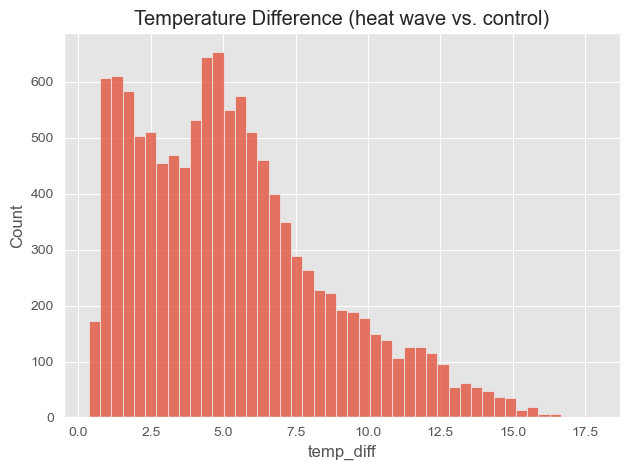

In [10]:
sns.histplot(mobility_heat, x='temp_diff')
plt.title("Temperature Difference (heat wave vs. control)")
plt.tight_layout()
plt.savefig(data_path + '/img/12_09_2023/india_temp_diff_dist.png')

### Build Duration Variable
* Duration of heat wave (in days)
* Build variable showing which day of a heatwave it is (stage)

In [11]:
# Formatting column names and merging dataframes

In [12]:
heatwave_control.sort_values(by='Heat Wave Duration', inplace=True)

In [13]:
duration_IDs = heatwave_control.drop_duplicates('heat_ID')[['heat_ID', 'Heat Wave Duration']  ]             

In [14]:
duration_IDs.columns = ['heat_ID', 'Heat Wave Duration']

In [15]:
#drop original heatwave duration variable
heatwave_control.drop('Heat Wave Duration', axis=1, inplace=True)

In [16]:
#merge duration ID dataframe onto heatwave control
heatwave_control = heatwave_control.merge(duration_IDs, on='heat_ID', how='left')

In [17]:
heatwave_control.drop_duplicates(['location', 'datetime'], inplace=True)

In [18]:
heatwave_control['dur_ranking'] = heatwave_control['Heat Wave Duration'].rank(pct=True)

In [19]:
#groupby each heatwave, sort by date, assign increasing rank for each passing day
heat_stage = heatwave_control.groupby('heat_ID').apply(lambda x: x.datetime.sort_values().rank()).reset_index()

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_57246/111197883.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heat_stage = heatwave_control.groupby('heat_ID').apply(lambda x: x.datetime.sort_values().rank()).reset_index()


In [20]:
heat_stage.columns=['heat_ID', 'index', 'stage']

In [21]:
heat_stage['stage'].max()

np.float64(15.0)

In [22]:
x = heat_stage.merge(duration_IDs, on='heat_ID')

In [23]:
heatwave_control.drop('index', axis=1, inplace=True)

In [24]:
heatwave_control.reset_index(inplace=True)

In [25]:
heatwave_control = heatwave_control.merge(heat_stage, on=['index', 'heat_ID'])

In [26]:
heatwave_control['datetime'] = pd.to_datetime(heatwave_control['datetime'])

In [27]:
heatwave_control['stage'].max()

np.float64(15.0)

In [28]:
mobility_heat['date_heat'] = pd.to_datetime(mobility_heat['date_heat'])

In [29]:
#merge temporal variables into mobility_heat

mobility_heat = mobility_heat.merge(heatwave_control[['location', 'datetime', 'Heat Wave Duration', 'dur_ranking', 'stage']], left_on=['location', 'date_heat'], right_on=['location', 'datetime'])

In [30]:
mobility_heat.reset_index(inplace=True)

In [31]:
mobility_heat['month'] = [x.month for x in mobility_heat['datetime']]

In [32]:
mobility_heat['month'].unique()

array([11, 12,  1,  2,  3])

In [33]:
#sorts heatwaves together
unique_IDs = heatwave_control.drop_duplicates('heat_ID')
unique_IDs = unique_IDs[['heat_ID']]

mobility_heat = mobility_heat.merge(unique_IDs, on='heat_ID')

In [34]:
# format final variables
mobility_heat['stage_frac'] = (mobility_heat['stage'] / mobility_heat['Heat Wave Duration'] )
mobility_heat['heatwave_dur'] = mobility_heat['Heat Wave Duration'] >= 4

In [35]:
mobility_heat['month'] = [x.month for x in pd.to_datetime(mobility_heat['date_control'])]

In [36]:
mobility_heat['date_control'] = pd.to_datetime(mobility_heat['date_control'])

In [37]:
mobility_heat['date_control']

0       2021-11-15
1       2021-11-09
2       2021-12-17
3       2021-12-11
4       2021-11-21
           ...    
11787   2022-01-12
11788   2022-01-13
11789   2022-01-15
11790   2022-01-16
11791   2022-01-17
Name: date_control, Length: 11792, dtype: datetime64[ns]

## Merge social and physical variables

In [38]:
soc_phys = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/physical/brazil/merged_Global2.shp')

In [39]:
mobility_heat= mobility_heat.merge(soc_phys[['location', 'mean_elev', 'coast', 'HDI_dec', 'popdens_de', 'over60_dec']], on='location')

In [40]:
mobility_heat['elev_1500m'] = mobility_heat['mean_elev'] >= 1500

In [41]:
mobility_heat['elev_1500m'] = mobility_heat['elev_1500m'] * 1

In [42]:
mobility_heat

,index,Unnamed: 0.1,Unnamed: 0,country_region_code,country_region,adm1,adm2,metro_area,iso_3166_2_code,census_fips_code,...,stage,month,stage_frac,heatwave_dur,mean_elev,coast,HDI_dec,popdens_de,over60_dec,elev_1500m
0,0,0,1349,BR,Brazil,Acre,Brasileia,NaN,NaN,NaN,...,1.0,11,0.500000,False,273.885524,0,1,2,1,0
1,1,1,1350,BR,Brazil,Acre,Brasileia,NaN,NaN,NaN,...,2.0,11,1.000000,False,273.885524,0,1,2,1,0
2,2,2,1390,BR,Brazil,Acre,Brasileia,NaN,NaN,NaN,...,1.0,12,0.333333,False,273.885524,0,1,2,1,0
3,3,3,1755,BR,Brazil,Acre,Cruzeiro do Sul,NaN,NaN,NaN,...,1.0,12,0.333333,False,224.920316,0,1,3,1,0
4,4,4,1756,BR,Brazil,Acre,Cruzeiro do Sul,NaN,NaN,NaN,...,2.0,11,0.666667,False,224.920316,0,1,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11787,11787,11787,571848,BR,Brazil,Sao Paulo,Votorantim,NaN,NaN,NaN,...,1.0,1,0.500000,False,769.791304,0,10,10,3,0
11788,11788,11788,571849,BR,Brazil,Sao Paulo,Votorantim,NaN,NaN,NaN,...,2.0,1,1.000000,False,769.791304,0,10,10,3,0
11789,11789,11789,572132,BR,Brazil,Sao Paulo,Votuporanga,NaN,NaN,NaN,...,1.0,1,0.333333,False,467.807547,0,10,10,8,0
11790,11790,11790,572133,BR,Brazil,Sao Paulo,Votuporanga,NaN,NaN,NaN,...,2.0,1,0.666667,False,467.807547,0,10,10,8,0


### Remove holidays 

In [43]:
import requests

In [44]:
hols_2021 = pd.DataFrame(requests.get("https://date.nager.at/api/v3/publicholidays/2021/BR").json())
hols_2022 = pd.DataFrame(requests.get("https://date.nager.at/api/v3/publicholidays/2022/BR").json())
hols = pd.concat([hols_2021, hols_2022])
hols['date'] = pd.to_datetime(hols['date'])

In [45]:
mobility_heat = mobility_heat[~mobility_heat['datetime_heat'].isin(hols['date'].values)]
mobility_heat = mobility_heat[~mobility_heat['datetime_control'].isin(hols['date'].values)]

## Normalized rain variable for heatwave and control day

In [46]:
precip = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/precipitation/brazil/daily_sum_precipitation.csv')
precip.rename(columns={'valid_time': 'time'}, inplace=True)
precip['time'] = pd.to_datetime(precip['time'])

In [47]:
gdf = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/adm0_shp/brazil/clean_shp.shp')
gdf.set_crs(epsg='4326', inplace=True)
gdf['location'] = gdf['adm2'] + ', ' + gdf['adm1']
gdf.to_crs(epsg='3857', inplace=True)
gdf['area'] = [x.area for x in gdf['geometry']]

In [48]:
#rain from m --> mm
precip['daily_precipitation'] = precip['daily_precipitation'] * 1000

In [49]:
#area from m --> km

gdf['area'] = gdf['area'] / 1000

In [50]:
precip = precip.merge(gdf[['location', 'area']], on='location')
precip['rain_normed'] = (precip['daily_precipitation'] / precip['area']) 

In [51]:
precip['rain_standard'] = precip.groupby('location')['rain_normed'].rank(pct=True) * 100

### Control day rain dummy

In [52]:
mobility_heat = mobility_heat.merge(precip[['time', 'adm1', 'adm2', 'rain_standard']], left_on=['control_day', 'adm1', 'adm2'], right_on=['time', 'adm1', 'adm2'])

In [53]:
mobility_heat.rename(columns={'rain_standard': "rain_standard_control"}, inplace=True)

### Heatwave day rain dummy

In [54]:
mobility_heat = mobility_heat.merge(precip[['time', 'adm1', 'adm2', 'rain_standard']], left_on=['date_heat', 'adm1', 'adm2'], right_on=['time', 'adm1', 'adm2'])

In [55]:
mobility_heat.rename(columns={'rain_standard': "rain_standard_heat"}, inplace=True)

### Prepare final dataset

In [56]:
df = mobility_heat.copy()

In [57]:
df = df[df['mean_elev'] <= 2500]

In [58]:
#set outlier cutoff (how many SDs away from mean)
SD = 4

In [59]:
for variable in ['workplaces_difference', 'residential_difference', 'grocery_pharm_difference', 'parks_difference', 'retail_rec_difference', 'transit_difference']:
    df[variable] = [np.nan if (x >= df[variable].mean() + (SD * df[variable].std())) | (x <= df[variable].mean() - (SD * df[variable].std())) else x for x in df[variable] ]

    #v13
df.dropna(how='all', subset=['workplaces_difference', 'residential_difference', 'transit_difference', 'grocery_pharm_difference', 'parks_difference', 'retail_rec_difference'], inplace=True)

In [60]:
df = df.iloc[:, 3:]

In [61]:
df.reset_index(inplace=True)

In [62]:
df[['residential_difference', 'workplaces_difference', 'transit_difference', 'grocery_pharm_difference', 'retail_rec_difference', 'parks_difference']].describe().transpose()[['count', 'mean', 'std', 'min', 'max']]

,count,mean,std,min,max
residential_difference,5230.0,0.299044,2.303526,-9.0,10.0
workplaces_difference,11069.0,-0.027825,14.202106,-69.0,68.0
transit_difference,2416.0,-3.572848,16.728983,-88.0,69.0
grocery_pharm_difference,3825.0,-3.128889,15.408010,-81.0,72.0
retail_rec_difference,4128.0,-3.220203,13.867723,-65.0,60.0
parks_difference,3352.0,-2.017900,25.379477,-121.0,115.0


In [63]:
df[['residential_difference', 'workplaces_difference', 'transit_difference', 'grocery_pharm_difference', 'retail_rec_difference', 'parks_difference']].describe().transpose()[['count', 'mean', 'std', 'min', 'max']]

,count,mean,std,min,max
residential_difference,5230.0,0.299044,2.303526,-9.0,10.0
workplaces_difference,11069.0,-0.027825,14.202106,-69.0,68.0
transit_difference,2416.0,-3.572848,16.728983,-88.0,69.0
grocery_pharm_difference,3825.0,-3.128889,15.408010,-81.0,72.0
retail_rec_difference,4128.0,-3.220203,13.867723,-65.0,60.0
parks_difference,3352.0,-2.017900,25.379477,-121.0,115.0


In [64]:
df['date_heat'].max()

Timestamp('2022-03-25 00:00:00')

In [65]:
df.to_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/brazil/THI_mobility_heat_w_vars_90_{SD}SD_precip_Global2.csv')